# Siamese Network for Forgery Detection

### Define Source Path as necessary to retrieve the data

In [ ]:
# Imports and Data
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import math
import random
# for converting data to tensors before feeding into network
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from google.colab.patches import cv2_imshow
from google.colab import drive

from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path in gdrive
source_path = "/content/drive/MyDrive/Handwriting Recognition"
raw_data_path = source_path + "/signature_data_raw/"
forged_data = raw_data_path + "forged/"
genuine_data = raw_data_path + "genuine/"

# Functional for Processing our Raw data

In [ ]:
# Data Preprocessing
def load_image(image_path):
    src = cv2.imread(image_path)
    #print(src)
    return src

def convert_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def display_image(image):
    cv2_imshow(image)

def flip_vertical(image):
    '''
    Mirrors the image over the x axis
    '''
    return cv2.flip(image, 0)

def flip_horizontal(image):
    '''
    Mirrors the image over the y axis
    '''
    return cv2.flip(image, 1)

def flip_both(image):
    '''
    Mirrors the images over both the x and the y axis
    '''
    return cv2.flip(image, -1)

# Resizing All of The Images

---



In [ ]:
def resize_image(image, width, height):
    '''
    Resizes the image to the dimensions that we want (e.g. 250x70)
    '''
    resized_image = cv2.resize(image, (width, height))
    return resized_image

def resize_all(path, resized_path, new_width, new_height):
    '''
    Creates new folder of data with all of the resized images (original, mirrored)
    '''
    for file_name in os.listdir(path):
        # original image
        img_path = path + file_name
        img = load_image(img_path)
        img = convert_grayscale(img) # convert to gray
        img = resize_image(img, new_width, new_height) # resize
        file_name = file_name[9:12] + file_name[7:9]

        new_image_path = resized_path + file_name + ".jpeg"
        cv2.imwrite(new_image_path, img) # save

        # image mirrored vertically
        vert_image = flip_vertical(img)
        new_image_path = resized_path + file_name + "vert.jpeg"
        cv2.imwrite(new_image_path, vert_image) # save

        # image flipped horizontal
        h_image = flip_horizontal(img)
        new_image_path = resized_path + file_name + "horiz.jpeg"
        cv2.imwrite(new_image_path, h_image) # save

        # image flipped both axes
        b_image = flip_both(img)
        new_image_path = resized_path + file_name + "both.jpeg"
        cv2.imwrite(new_image_path, b_image) # save

# Genuine Data Resized w/ Mirroring


Needed from above:
```
genuine_data
```



In [ ]:
# resized_path = "/content/drive/MyDrive/Handwriting Recognition/resized_signature_data/genuine_resized/"
# new_width, new_height = 200, 75
# if not os.path.exists(resized_path):
#     os.mkdir(resized_path)
# resize_all(genuine_data, resized_path, new_width, new_height)

# Forged Data Resized w/ Mirroring

Needed from above
```
forged_data
```

In [ ]:
# resized_path = "/content/drive/MyDrive/Handwriting Recognition/resized_signature_data/forged_resized/"
# new_width, new_height = 200, 75
# if not os.path.exists(resized_path):
#     os.mkdir(resized_path)
# resize_all(forged_data, resized_path, new_width, new_height)

# Conversion to Tensors to Get Data Ready for Training

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # normalization of pixel values
])

f_path = "/content/drive/MyDrive/Handwriting Recognition/resized_signature_data/forged_resized/"
g_path = "/content/drive/MyDrive/Handwriting Recognition/resized_signature_data/genuine_resized/"

g_images = []
f_images = []
g_labels = []
f_labels = []

genuine_files = 0 # adding the genuine files to the set of images
for file_name in sorted(os.listdir(g_path)):
    img_path = g_path + file_name
    img = load_image(img_path)
    img = transform(img) # transfrom image to Tensor
    g_images.append((img, file_name))
    label = 1
    g_labels.append(label)
    genuine_files += 1

forged_files = 0
for file_name in sorted(os.listdir(f_path)): # adding the forged files to the set of iamges
    img_path = f_path + file_name
    img = load_image(img_path)
    img = transform(img) # transform image to tensor
    f_images.append((img, file_name))
    label = 0
    f_labels.append(label)
    forged_files += 1

# Custom Dataset Class

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, genuine_tups, forged_tups):
        '''a tuple is an (image, title) pair'''
        super().__init__()
        print(f"number of genuine samples: {len(genuine_tups)}, number of forged samples {len(forged_tups)}")
        self.dataset = self.create_dataset(genuine_tups, forged_tups)
        print(f"Total dataset length: {self.__len__()}")

    def create_dataset(self, genuine, forged):
        ''' we want half the images to match'''
        dataset = []

        # we add genuine pairs first
        for img, title in genuine:
            found = False
            id, version, rotation = title[:3], title[3:5], title[5:9] # get whose signature it is
            # first see if we can get a different sample from the same person
            for i,t in genuine:
                if t[:3]==id and t[3:5]!=version and t[5:9]==rotation:
                    dataset.append((img, i, 1))
                    found = True
                    break
            if found: continue
            # if we were not able to get a different sample, just get a rotation
            for i,t in genuine:
                if t[:3]==id and t[5:9]==rotation and title!=t:
                    dataset.append((img, i, 1))
                    found = True
                    break
            print(f"No matching genuine picture found for person {id} ({title})")

        # now we add forged pairs first - I am going to keep all real images on the left
        for img, title in forged:
            id, version, rotation = title[:3], title[3:5], title[5:9] # get whose signature it is
            for i,t in genuine: # find a matching enuine sample
                if t[:3]==id and t[5:9]==rotation:
                    dataset.append((i, img, 0))
                    break
        random.shuffle(dataset)
        return dataset

    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

# Split into Train/Validate/Test

In [ ]:
# batch_size = 64
number_gsamples = len(g_images)
number_fsamples = len(f_images)
training_split = 0.6
validation_split = 0.2

training_data = SiameseDataset(g_images[1:int(number_gsamples*training_split)], f_images[:int(number_fsamples*training_split)-1])
validation_data = SiameseDataset(g_images[int(number_gsamples*training_split):int(number_gsamples*training_split+number_gsamples*validation_split)], f_images[int(number_fsamples*training_split)-1:int(number_fsamples*training_split+number_fsamples*validation_split)])
test_data = SiameseDataset(g_images[int(number_gsamples*training_split+number_gsamples*validation_split):], f_images[int(number_fsamples*training_split+number_fsamples*validation_split):])

training_data_size = training_data.__len__()

train_dataloader = DataLoader(training_data, batch_size=65, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=60, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=60, shuffle=True)

number of genuine samples: 359, number of forged samples 356
Total dataset length: 715
number of genuine samples: 120, number of forged samples 120
Total dataset length: 240
number of genuine samples: 120, number of forged samples 120
Total dataset length: 240


In [ ]:
def display_tensors(data_tensor0, data_tensor1):
    '''Display tensor data of an image as an image'''
    numpy_img0 = data_tensor0
    numpy_img1 = data_tensor1
    if numpy_img0.shape[0] == 3:
        numpy_img0 = np.transpose(numpy_img0, (1, 2, 0))
    if numpy_img1.shape[0] == 3:
        numpy_img1 = np.transpose(numpy_img1, (1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(numpy_img0)
    plt.title('Image 0')
    plt.subplot(1, 2, 2)
    plt.imshow(numpy_img1)
    plt.title('Image 1')
    plt.show()


# Set up Network

In [ ]:
class SiameseNetwork(nn.Module):
    '''
    Siamese Network module
    '''
    # self.contrastive_loss = 0.5*(1-Y)*(Dw**2) + 0.5*Y*(max(0,m-Dw))**2
    # self.Dw = lambda x1,x2: math.sqrt(math.pow(Gw(x1)-Gw(x2),2))

    threshold = 30
    threshold_lr = 0.01

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Assuming input images are of size [3, 75, 200]
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(4)
        )


        self.fc1 = nn.Sequential(
            nn.Linear(640, 4096),
            nn.ReLU(),
            nn.Dropout(0.2),  # lowered dropout
            nn.Linear(4096, 1)
        )


    def forward_once(self, x):
        output = self.cnn1(x)
        #output = self.adaptive_pool
        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    def evaluate(self, dataloader):
        # Switch the network to evaluation mode
        self.eval()
        eval_loss = ContrastiveLoss()

        correct_pairs = 0
        total_pairs = 0

        match_pairs = 0
        forged_pairs = 0
        match_distances = []
        forged_distances = []
        curr_epoch_loss = 0
        # Iterate over the data loader
        for batch in dataloader:
            img_list_0, img_list_1, labels = batch # so store each item of the batch
            for i in range(dataloader.batch_size): # for each pair in batch
                img0 = img_list_0[i]
                img1 = img_list_1[i]
                label = labels[i]
                img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

                # do a prediction
                output1, output2 = self.forward(img0.unsqueeze(0),img1.unsqueeze(0))
                # Calculate the Euclidean distance between the outputs
                distance = F.pairwise_distance(output1, output2)

                # Check if the distance is less than a threshold for similar pairs
                # print("{:.5e} {}".format(torch.mean(distance).item(), label.item()))
                prediction = torch.mean(distance).item() > self.threshold
                label = label.item()
                loss_contrastive = eval_loss(output1,output2, labels[i].cuda(), euclidean_distance=distance)

                curr_epoch_loss += loss_contrastive.detach().cpu().numpy()
                if label == int(prediction):
                    correct_pairs+=1
                total_pairs += 1

                if label:
                    match_pairs += 1
                    match_distances.append(torch.mean(distance).item())
                else:
                    forged_pairs += 1
                    forged_distances.append(torch.mean(distance).item())

        accuracy = 1.0*correct_pairs / total_pairs
        # print(f"Accuracy is: {accuracy}")
        return accuracy, curr_epoch_loss

    def evaluate_one(self, img0, img1, label):
        self.eval()
        # do a prediction
        output1, output2 = self.forward(img0.unsqueeze(0),img1.unsqueeze(0))
        # Calculate the Euclidean distance between the outputs
        distance = F.pairwise_distance(output1, output2)

        # Check if the distance is less than a threshold for similar pairs
        prediction = torch.mean(distance).item() < self.threshold

        if label == int(prediction):
            return 1
        return 0

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    https://medium.com/hackernoon/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    """

    def __init__(self, margin=40.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label, euclidean_distance=None):
        if not euclidean_distance:
          euclidean_distance = F.pairwise_distance(output1, output2)
        # print(f"match? {label}; distance: {euclidean_distance.item()}")
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

#Training

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch number 1: Cumulative Loss 5.12359e+05


  5%|▌         | 1/20 [00:04<01:18,  4.13s/it]

Epoch number 2: Cumulative Loss 5.51663e+05


 10%|█         | 2/20 [00:07<01:08,  3.79s/it]

Epoch number 3: Cumulative Loss 4.18974e+05


 15%|█▌        | 3/20 [00:11<01:08,  4.00s/it]

Epoch number 4: Cumulative Loss 3.73572e+05


 20%|██        | 4/20 [00:15<01:01,  3.82s/it]

Epoch number 5: Cumulative Loss 3.31123e+05


 25%|██▌       | 5/20 [00:19<00:55,  3.72s/it]

Epoch number 6: Cumulative Loss 3.12808e+05


 30%|███       | 6/20 [00:22<00:52,  3.73s/it]

Epoch number 7: Cumulative Loss 3.00092e+05


 35%|███▌      | 7/20 [00:27<00:52,  4.07s/it]

Epoch number 8: Cumulative Loss 2.62248e+05


 40%|████      | 8/20 [00:32<00:50,  4.23s/it]

Epoch number 9: Cumulative Loss 2.26705e+05


 45%|████▌     | 9/20 [00:35<00:44,  4.00s/it]

Epoch number 10: Cumulative Loss 1.83343e+05


 50%|█████     | 10/20 [00:39<00:40,  4.07s/it]

Epoch number 11: Cumulative Loss 1.82368e+05


 55%|█████▌    | 11/20 [00:43<00:35,  3.90s/it]

Epoch number 12: Cumulative Loss 1.76915e+05


 60%|██████    | 12/20 [00:46<00:30,  3.80s/it]

Epoch number 13: Cumulative Loss 1.61490e+05


 65%|██████▌   | 13/20 [00:50<00:26,  3.84s/it]

Epoch number 14: Cumulative Loss 1.48888e+05


 70%|███████   | 14/20 [00:54<00:22,  3.83s/it]

Epoch number 15: Cumulative Loss 1.36228e+05


 75%|███████▌  | 15/20 [00:58<00:18,  3.72s/it]

Epoch number 16: Cumulative Loss 1.56861e+05


 80%|████████  | 16/20 [01:01<00:14,  3.66s/it]

Epoch number 17: Cumulative Loss 1.38220e+05


 85%|████████▌ | 17/20 [01:05<00:11,  3.82s/it]

Epoch number 18: Cumulative Loss 1.11520e+05


 90%|█████████ | 18/20 [01:09<00:07,  3.73s/it]

Epoch number 19: Cumulative Loss 9.83933e+04


 95%|█████████▌| 19/20 [01:12<00:03,  3.67s/it]

Epoch number 20: Cumulative Loss 9.63558e+04


100%|██████████| 20/20 [01:16<00:00,  3.84s/it]


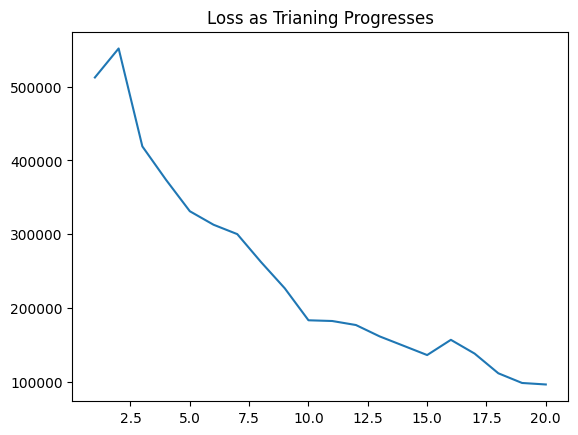

Validation Accuracy Achieved: (0.5, 156315.9600751996)



In [ ]:
# plotting function
def show_plot(iteration,loss, title):
    plt.plot(iteration,loss)
    plt.title(title)
    plt.show()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# ----------------------CHANGE----------------------------#
my_starting_weights = "/content/drive/MyDrive/Handwriting Recognition/500_EPOCH_MODEL.pth.pth"
# --------------------------------------------------------#
epochs = 20
save = False
load = False

#Training
network = SiameseNetwork().cuda()
if load:
  print(f"Loading the weights from {my_starting_weights} ...")
  network.load_state_dict(torch.load(my_starting_weights))
  print("Successfully loaded the model checkpoint!")

loss = ContrastiveLoss()
optimizer = torch.optim.Adam(network.parameters(),lr = 0.01)

counter = []
acc_history = []
loss_history = []
val_loss = []

network.train()
for epoch in tqdm(range(epochs)):
    cur_epoch_loss = 0
    for batch in train_dataloader:

        optimizer.zero_grad() # Clears the gradients of all optimized tensors
        img_list_0, img_list_1, labels = batch # store each item of the batch

        for i in range(train_dataloader.batch_size):
            output1, output2 = network(img_list_0[i].cuda().unsqueeze(0), img_list_1[i].cuda().unsqueeze(0)) # Forward pass
            euclidean_distance = F.pairwise_distance(output1, output2)
            loss_contrastive = loss(output1,output2, labels[i].cuda(), euclidean_distance) # Compute the loss
            loss_contrastive.backward() # Backward pass to compute gradients
            cur_epoch_loss += loss_contrastive.detach().cpu().numpy()


        optimizer.step() # Update weights
    # evaluate at each epoch
    print("Epoch number {}: Cumulative Loss {:.5e}".format(epoch+1,cur_epoch_loss))
    acc, validation_l = network.evaluate(validation_dataloader)
    val_loss.append(validation_l)
    #print(f'Train Accuracy Achieved: {acc}\n')
    acc_history.append(acc)
    loss_history.append(cur_epoch_loss)
    counter.append(epoch+1)

#show_plot(counter,acc_history, "Accuracy as Trianing Progresses")
#show_plot(counter, val_loss, "Validation Loss")
show_plot(counter,loss_history, "Loss as Trianing Progresses")



# ----------------------CHANGE----------------------------#
if save:
  my_best_model = "/content/drive/MyDrive/Handwriting Recognition/500_EPOCH_MODEL.pth"
  torch.save(network.state_dict(), my_best_model)
  print(f"model saved to {my_best_model}")
# --------------------------------------------------------#

acc = network.evaluate(validation_dataloader)
print(f'Validation Accuracy Achieved: {acc}\n')

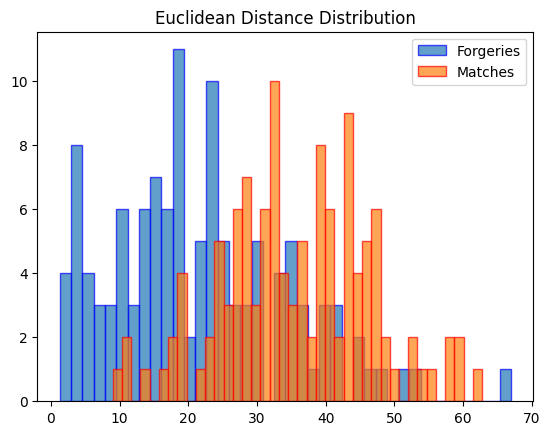

In [ ]:
data_loader = train_dataloader
data_loader = test_dataloader
data_iter = iter(data_loader)
maximum = -1
minimum = 10000
count = 0
total = 0
vals = []
forged_distances = []
true_distances = []

while data_iter:
  try:
    img0, img1, train_label = next(data_iter)
    for i in range(data_loader.batch_size):
      output1, output2 = network(img0[i].cuda().unsqueeze(0),img1[i].cuda().unsqueeze(0))
      euclidean_distance = F.pairwise_distance(output1, output2)
      count+=1
      maximum = max(maximum, euclidean_distance.item())
      minimum = min(minimum, euclidean_distance.item())
      total += euclidean_distance.item()
      vals.append(euclidean_distance.item())
      if train_label[i].item():
        true_distances.append(euclidean_distance.item())
      else:
        forged_distances.append(euclidean_distance.item())
  except StopIteration:
    break

plt.hist(forged_distances, bins=40, label='Forgeries', alpha=.7, edgecolor='blue')
plt.hist(true_distances, bins=40, label='Matches', alpha=.7, edgecolor='red')
plt.title("Euclidean Distance Distribution")
plt.legend()
plt.show()

# Testing

In [ ]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#my_starting_weights = "/content/drive/MyDrive/Handwriting Recognition/best_model.pth"
#network = SiameseNetwork().cuda()
#if not network: # load weights
#  print(f"Loading the weights from {my_starting_weights} ...")
#  network.load_state_dict(torch.load(my_starting_weights))
#  print("Successfully loaded the model checkpoint!")
# evaluate on testing data
acc, loss = network.evaluate(test_dataloader)
print(f"Test Accuracy on {epochs} Epoch Model: {acc*100:.2f}%")

Test Accuracy on 20 Epoch Model: 71.67%


In [ ]:
acc, loss = network.evaluate(train_dataloader)
print(f"Train Accuracy on {epochs} Epoch Model: {acc*100:.2f}%")

Train Accuracy on 20 Epoch Model: 87.41%
